In [2]:
import pickle
import sys, os
import cv2 as cv
import h5py
import copy
import matplotlib.pyplot as plt
import numpy as np
from itertools import repeat

np.set_printoptions(suppress=True)

%load_ext autoreload
%autoreload 2

In [22]:
util_path = os.path.abspath("../utils/")
sys.path.append(util_path)
import color_seg as seg



In [4]:
def disp_hdf5_structure(hdf5_file):
    with h5py.File(hdf5_file, 'r') as f:
        # Print the file structure recursively
        def print_structure(name, obj):
            if isinstance(obj, h5py.Group):
                print(name)
                for key in obj.keys():
                    print_structure(f"{name}/{key}", obj[key])
            else:
                print(f"{name}: {obj.shape}, {obj.dtype}")

        print_structure('/', f)

In [5]:
act_path = "/home/zfei/code/act-plus-plus/"
sys.path.append(act_path)
from utils import EpisodicDataset
from utils import find_all_hdf5, flatten_list, get_norm_stats


In [104]:
dataset_path_list = find_all_hdf5("/mnt/data1/act/train_act_scara_sim-env-block-pick/", skip_mirrored_data=False)
dataset_path_list.sort()
dataset_path_list

Found 511 hdf5 files


['/mnt/data1/act/train_act_scara_sim-env-block-pick/data1/episode_0.hdf5',
 '/mnt/data1/act/train_act_scara_sim-env-block-pick/data1/episode_1.hdf5',
 '/mnt/data1/act/train_act_scara_sim-env-block-pick/data1/episode_10.hdf5',
 '/mnt/data1/act/train_act_scara_sim-env-block-pick/data1/episode_100_val.hdf5',
 '/mnt/data1/act/train_act_scara_sim-env-block-pick/data1/episode_101.hdf5',
 '/mnt/data1/act/train_act_scara_sim-env-block-pick/data1/episode_102.hdf5',
 '/mnt/data1/act/train_act_scara_sim-env-block-pick/data1/episode_103.hdf5',
 '/mnt/data1/act/train_act_scara_sim-env-block-pick/data1/episode_104.hdf5',
 '/mnt/data1/act/train_act_scara_sim-env-block-pick/data1/episode_105.hdf5',
 '/mnt/data1/act/train_act_scara_sim-env-block-pick/data1/episode_106.hdf5',
 '/mnt/data1/act/train_act_scara_sim-env-block-pick/data1/episode_107.hdf5',
 '/mnt/data1/act/train_act_scara_sim-env-block-pick/data1/episode_108.hdf5',
 '/mnt/data1/act/train_act_scara_sim-env-block-pick/data1/episode_109.hdf5',


In [103]:
data_idx = 0
dataset_path = dataset_path_list[data_idx]
print(dataset_path)
seg_aug_path = dataset_path.replace("episode_", "epi_segaug_")
print(seg_aug_path)

/mnt/data1/act/train_act_scara_sim-env-block-pick/data1/episode_0.hdf5
/mnt/data1/act/train_act_scara_sim-env-block-pick/data1/epi_segaug_0.hdf5


In [8]:
disp_hdf5_structure(dataset_path)

/
//action: (333, 5), float32
//observations
//observations/images
//observations/images/top: (333, 480, 640, 3), uint8
//observations/images/wrist: (333, 480, 640, 3), uint8
//observations/images/wrist_down: (333, 480, 640, 3), uint8
//observations/qpos: (333, 4), float32


In [67]:
# Load the dataset
camera_names = ['wrist', 'wrist_down']
data_dict = {}
for cam_name in camera_names:
    data_dict[f'/observations/images/{cam_name}'] = []

aug_data_dict = {}
for cam_name in camera_names:
    aug_data_dict[f'/observations/images/{cam_name}'] = []
    
with h5py.File(dataset_path, 'r') as root:
      for cam_name in camera_names:
        for i in range(len(root[f'/observations/images/{cam_name}'])):
          image = root[f'/observations/images/{cam_name}'][i]
          data_dict[f'/observations/images/{cam_name}'].append(image)
         
            

In [68]:
# Inference and get the target segmentation image
roi_mean = [139.83333333,  26.30666667,  31.17333333, 147.52, 207.39333333, 139.83333333]
roi_std = [6.57816253,  7.12642656, 7.77409945, 67.53445738, 11.85461748, 6.57816253]
threshold = 20


In [69]:
for cam_name in camera_names:
    for i in range(len(data_dict[f'/observations/images/{cam_name}'])):
        img_rgb = cv.cvtColor(data_dict[f'/observations/images/{cam_name}'][i], cv.COLOR_BGR2RGB)
        segmentation, distance_map = seg.segment(img_rgb, roi_mean, roi_std, threshold, var_weighting=False)
        seg_img = copy.deepcopy(img_rgb)
        seg_img[segmentation == 0] = 0
        aug_data_dict[f'/observations/images/{cam_name}'].append(cv.cvtColor(seg_img, cv.COLOR_RGB2BGR))
        break

In [70]:

# Write the augmented dataset
# create segaug hdf5 file
with h5py.File(seg_aug_path, 'w', rdcc_nbytes=1024 ** 2 * 2) as aug_root:
   obs = aug_root.create_group('observations')
   image = obs.create_group('images_target_seg')
   for cam_name in camera_names:
      image.create_dataset(cam_name, data=aug_data_dict[f'/observations/images/{cam_name}'])
print(f"Creating segaug hdf5 file at {seg_aug_path} done")
disp_hdf5_structure(seg_aug_path)
         

Creating segaug hdf5 file at /mnt/data1/act/train_act_scara_sim-env-block-pick/data1/episode_segaug_0.hdf5 done
/
//observations
//observations/images_target_seg
//observations/images_target_seg/wrist: (1, 480, 640, 3), uint8
//observations/images_target_seg/wrist_down: (1, 480, 640, 3), uint8


In [99]:
image = None
image_target_seg = None
with h5py.File(dataset_path, 'r') as root:
    idx = 70
    image = root[f'/observations/images/wrist_down'][idx]
    with h5py.File(seg_aug_path, 'r') as aug_root:
        print(len(aug_root[f'/observations/images_target_seg/wrist_down']))
        image_target_seg = aug_root[f'/observations/images_target_seg/wrist_down'][idx]



333


Text(0.5, 1.0, 'Augmented Image')

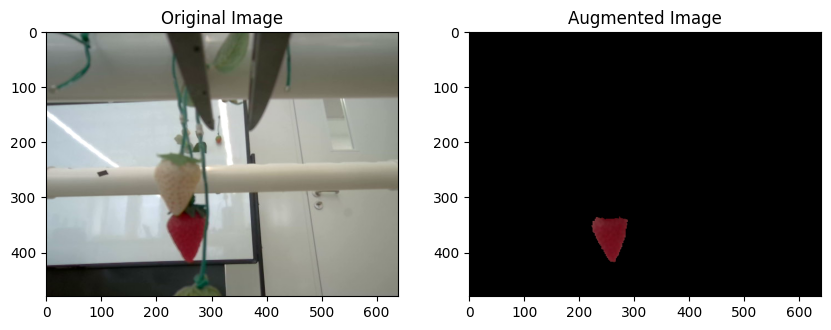

In [100]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
ax[0].set_title("Original Image")
ax[1].imshow(cv.cvtColor(image_target_seg, cv.COLOR_BGR2RGB))
ax[1].set_title("Augmented Image")

In [102]:
dataset_path_list

['/mnt/data1/act/train_act_scara_sim-env-block-pick/data1/episode_0.hdf5',
 '/mnt/data1/act/train_act_scara_sim-env-block-pick/data1/episode_1.hdf5',
 '/mnt/data1/act/train_act_scara_sim-env-block-pick/data1/episode_10.hdf5',
 '/mnt/data1/act/train_act_scara_sim-env-block-pick/data1/episode_100_val.hdf5',
 '/mnt/data1/act/train_act_scara_sim-env-block-pick/data1/episode_101.hdf5',
 '/mnt/data1/act/train_act_scara_sim-env-block-pick/data1/episode_102.hdf5',
 '/mnt/data1/act/train_act_scara_sim-env-block-pick/data1/episode_103.hdf5',
 '/mnt/data1/act/train_act_scara_sim-env-block-pick/data1/episode_104.hdf5',
 '/mnt/data1/act/train_act_scara_sim-env-block-pick/data1/episode_105.hdf5',
 '/mnt/data1/act/train_act_scara_sim-env-block-pick/data1/episode_106.hdf5',
 '/mnt/data1/act/train_act_scara_sim-env-block-pick/data1/episode_107.hdf5',
 '/mnt/data1/act/train_act_scara_sim-env-block-pick/data1/episode_108.hdf5',
 '/mnt/data1/act/train_act_scara_sim-env-block-pick/data1/episode_109.hdf5',


# The Big Loop

In [ ]:
camera_names = ['wrist', 'wrist_down']

for data_idx in range(len(dataset_path_list)):
    dataset_path = dataset_path_list[data_idx]
    print(dataset_path)
    seg_aug_path = dataset_path.replace("episode_", "epi_segaug_")
    print(seg_aug_path)

    # Load the dataset
    data_dict = {}
    for cam_name in camera_names:
        data_dict[f'/observations/images/{cam_name}'] = []

    aug_data_dict = {}
    for cam_name in camera_names:
        aug_data_dict[f'/observations/images/{cam_name}'] = []
        
    with h5py.File(dataset_path, 'r') as root:
        for cam_name in camera_names:
            for i in range(len(root[f'/observations/images/{cam_name}'])):
                image = root[f'/observations/images/{cam_name}'][i]
                img_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
                segmentation, distance_map = seg.segment(img_rgb, roi_mean, roi_std, threshold, var_weighting=False)
                seg_img = copy.deepcopy(img_rgb)
                seg_img[segmentation == 0] = 0
                aug_data_dict[f'/observations/images/{cam_name}'].append(cv.cvtColor(seg_img, cv.COLOR_RGB2BGR))

    # Write the augmented dataset
    # create segaug hdf5 file
    with h5py.File(seg_aug_path, 'w', rdcc_nbytes=1024 ** 2 * 2) as aug_root:
        obs = aug_root.create_group('observations')
        image = obs.create_group('images_target_seg')
        for cam_name in camera_names:
            image.create_dataset(cam_name, data=aug_data_dict[f'/observations/images/{cam_name}'])
    print(f"Creating segaug hdf5 file at {seg_aug_path} done")
    disp_hdf5_structure(seg_aug_path)


/mnt/data1/act/train_act_scara_sim-env-block-pick/data1/episode_0.hdf5
/mnt/data1/act/train_act_scara_sim-env-block-pick/data1/epi_segaug_0.hdf5
Creating segaug hdf5 file at /mnt/data1/act/train_act_scara_sim-env-block-pick/data1/epi_segaug_0.hdf5 done
/
//observations
//observations/images_target_seg
//observations/images_target_seg/wrist: (333, 480, 640, 3), uint8
//observations/images_target_seg/wrist_down: (333, 480, 640, 3), uint8
/mnt/data1/act/train_act_scara_sim-env-block-pick/data1/episode_1.hdf5
/mnt/data1/act/train_act_scara_sim-env-block-pick/data1/epi_segaug_1.hdf5
Creating segaug hdf5 file at /mnt/data1/act/train_act_scara_sim-env-block-pick/data1/epi_segaug_1.hdf5 done
/
//observations
//observations/images_target_seg
//observations/images_target_seg/wrist: (194, 480, 640, 3), uint8
//observations/images_target_seg/wrist_down: (194, 480, 640, 3), uint8
/mnt/data1/act/train_act_scara_sim-env-block-pick/data1/episode_10.hdf5
/mnt/data1/act/train_act_scara_sim-env-block-pic

In [112]:
aug_data_dict['/observations/images/wrist'][2].shape

(5763,)